In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive (4).zip"

Archive:  /content/drive/MyDrive/archive (4).zip
  inflating: README.roboflow.txt     
  inflating: data.yaml               
  inflating: train/images/img_0_jpg.rf.1ad6ef0c7277e7d97d16e93b52cf67a2.jpg  
  inflating: train/images/img_0_jpg.rf.a82c4cd8d9e87abe51d18c7dcca3176e.jpg  
  inflating: train/images/img_0_jpg.rf.b8e0218892782f85d1390cf649fba27d.jpg  
  inflating: train/images/img_100215_jpg.rf.2a45fabe3d31d1e5fb27a282fdfc253b.jpg  
  inflating: train/images/img_100215_jpg.rf.4c57f11bd3056af8abfab241988f2563.jpg  
  inflating: train/images/img_100215_jpg.rf.85fa94142c35d29d5cf32882b453eb60.jpg  
  inflating: train/images/img_100299_jpg.rf.1fe68601035a4d8b1d40eb800779c0af.jpg  
  inflating: train/images/img_100299_jpg.rf.91910f824961f06093b154bf53ba7461.jpg  
  inflating: train/images/img_100299_jpg.rf.da2268c26549ccbbbe3b304dea2ae9d6.jpg  
  inflating: train/images/img_100327_jpg.rf.5252b021e1155671397a41ebedf58851.jpg  
  inflating: train/images/img_100327_jpg.rf.82d5fd77018898f3

# Importing necessary libraries


In [ ]:
# PoseGuard: CNN Model for Driver Pose Detection

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Constants
IMAGE_SIZE = (224, 224)  # Increased image size
BATCH_SIZE = 32
EPOCHS = 50  # Increased epochs
NUM_CLASSES = 8
MODEL_PATH = '/content/drive/MyDrive/poseguard_model.h5'

In [ ]:
# Dataset Loader with improved preprocessing
def load_dataset(image_dir, label_dir):
    images, labels = [], []
    label_files = {file.split('.')[0]: file for file in os.listdir(label_dir)}

    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, label_files.get(img_file.split('.')[0], ''))

        if os.path.exists(label_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, IMAGE_SIZE)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # Better preprocessing

            with open(label_path, 'r') as file:
                label = int(file.readline().strip().split()[0])

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
# Load Data
train_images, train_labels = load_dataset("/content/data/train/images", "/content/data/train/labels")
val_images, val_labels = load_dataset("/content/data/valid/images", "/content/data/valid/labels")

In [ ]:
# One-hot encode labels
y_train = to_categorical(train_labels, NUM_CLASSES)
y_val = to_categorical(val_labels, NUM_CLASSES)

In [ ]:
# Train/test split
X_train, X_test, y_train_split, y_test_split = train_test_split(train_images, y_train, test_size=0.2, random_state=42)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [ ]:
def create_model(input_shape=(224, 224, 3), num_classes=8):
    # Using MobileNetV2 as base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Fine-tune from this layer onwards
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Compile with better optimizer settings
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Callbacks for better training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Load or Create Model
if os.path.exists(MODEL_PATH):
    print("Loading existing model...")
    model = load_model(MODEL_PATH)
else:
    print("Creating and training new model...")
    model = create_model()

    # Fit with data augmentation
    history = model.fit(
        datagen.flow(X_train, y_train_split, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_split),
        callbacks=[reduce_lr, early_stopping]
    )

    model.save(MODEL_PATH)
    print("Model saved.")

Creating and training new model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1374 - loss: 2.5716 - val_accuracy: 0.1481 - val_loss: 2.2251 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - accuracy: 0.2689 - loss: 2.0782 - val_accuracy: 0.1905 - val_loss: 2.2692 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 472ms/step - accuracy: 0.3675 - loss: 1.7324 - val_accuracy: 0.2275 - val_loss: 2.7436 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.5367 - loss: 1.2814 - val_accuracy: 0.2593 - val_loss: 2.9970 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.6902 - loss: 0.8623 - val_accuracy: 0.3228 - val_loss: 2.5889 - learning_rate: 2.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - accuracy: 0.7442 - loss: 0.7211 - val_accuracy: 0.3280 - val_loss: 3.0115 - learning_rate: 2.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.8168 - los

Model saved.


In [ ]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_images, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - loss: 1.2048
Validation Accuracy: 0.68


In [ ]:
# Generate Predictions
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


In [ ]:
# Report
print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       1.00      0.60      0.75         5
           2       1.00      0.50      0.67         2
           3       0.44      0.80      0.57         5
           4       0.60      1.00      0.75         3
           5       1.00      0.60      0.75         5
           6       0.67      0.40      0.50         5
           7       0.67      1.00      0.80        10

    accuracy                           0.68        40
   macro avg       0.80      0.64      0.64        40
weighted avg       0.78      0.68      0.65        40

[[ 1  0  0  4  0  0  0  0]
 [ 0  3  0  1  0  0  0  1]
 [ 0  0  1  0  0  0  1  0]
 [ 0  0  0  4  0  0  0  1]
 [ 0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  3  0  2]
 [ 0  0  0  0  2  0  2  1]
 [ 0  0  0  0  0  0  0 10]]


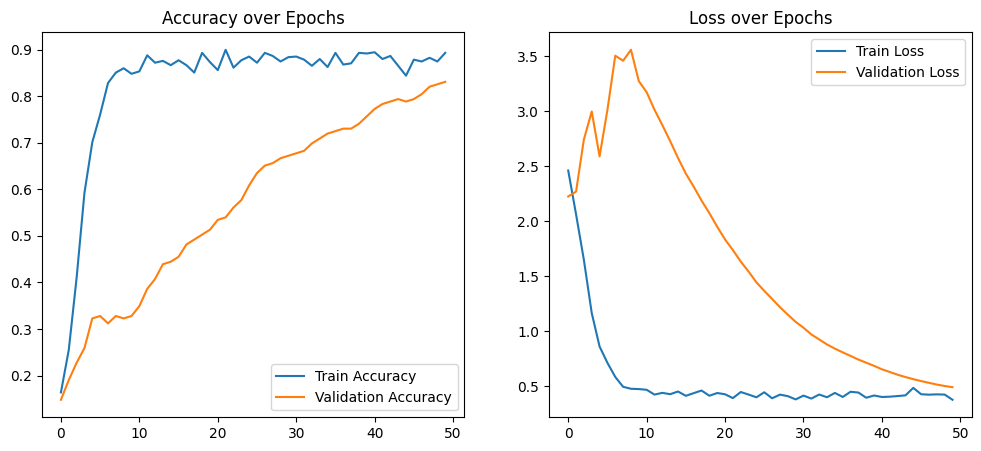

In [ ]:
# Visualization of accuracy & loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# Alert system
def generate_alert(predicted_class):
    alert_classes = [1, 2, 3, 4, 5, 6, 7]  # Unwanted poses
    if predicted_class in alert_classes:
        print("⚠️ ALERT: Unwanted Pose Detected! ⚠️")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


⚠️ ALERT: Unwanted Pose Detected! ⚠️


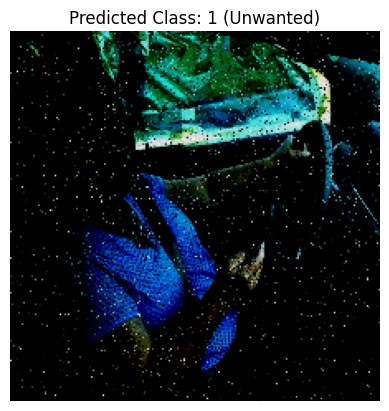

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


⚠️ ALERT: Unwanted Pose Detected! ⚠️


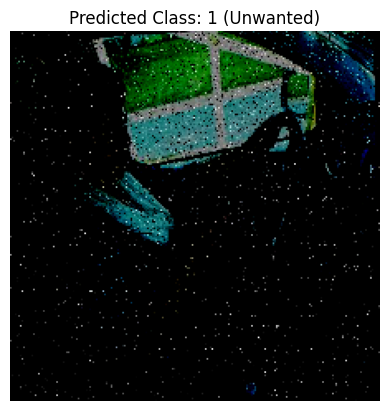

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


⚠️ ALERT: Unwanted Pose Detected! ⚠️


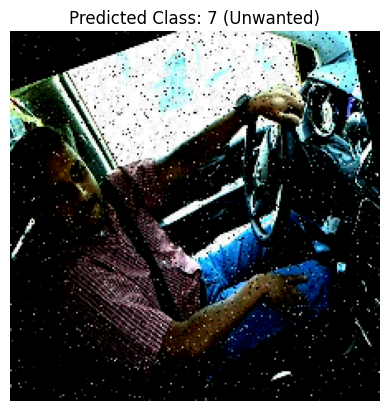

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


⚠️ ALERT: Unwanted Pose Detected! ⚠️


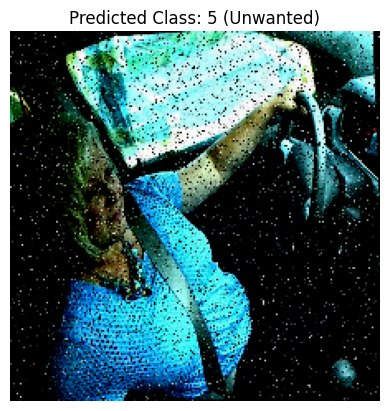

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


⚠️ ALERT: Unwanted Pose Detected! ⚠️


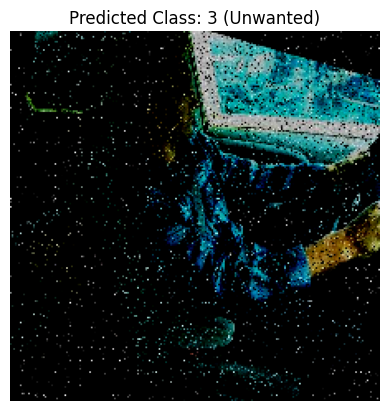

In [ ]:
# Testing with sample images from X_test
for i in range(5):
    sample_img = X_test[i]

    # Reshape and normalize (if not already normalized)
    img_input = sample_img.reshape(1, 224, 224, 3)

    # Predict
    prediction = model.predict(img_input)
    pred_class = np.argmax(prediction)

    # Call alert system (optional)
    generate_alert(pred_class)  # Make sure this function is defined

    # Display image with prediction
    plt.imshow(sample_img)
    plt.title(f"Predicted Class: {pred_class} ({'Safe' if pred_class == 0 else 'Unwanted'})")
    plt.axis('off')
    plt.show()
